In [ ]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Carga del archivo Excel
from google.colab import files
#uploaded = files.upload()

# Lectura del archivo
df = pd.read_excel("limpioML.xlsx")

# Visualización inicial

In [ ]:
df.head(50)
dfTarija = df.copy()

In [ ]:
# Suponiendo que tus datos van de enero 2000 a diciembre 2022 (264 meses)
df.index = pd.date_range(start='2001-01-01', periods=len(df), freq='M')


/tmp/ipython-input-952636221.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index = pd.date_range(start='2001-01-01', periods=len(df), freq='M')



================ Procesando CHUQUISACA (Walk-Forward) ================
Entrenando modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Métricas para CHUQUISACA (Walk-Forward 2022) ---
 MAE:  13,240.83
 RMSE: 18,154.10
 R2:   0.3693

================ Procesando COCHABAMBA (Walk-Forward) ================
Entrenando modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Métricas para COCHABAMBA (Walk-Forward 2022) ---
 MAE:  1,965.79
 RMSE: 3,008.65
 R2:   -1.2604

================ Procesando TARIJA (Walk-Forward) ================
Entrenando modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Métricas para TARIJA (Walk-Forward 2022) ---
 MAE:  23,788.35
 RMSE: 27,648.55
 R2:   0.1542

================ Procesando SANTA CRUZ (Walk-Forward) ================
Entrenando modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Métricas para SANTA CRUZ (Walk-Forward 2022) ---
 MAE:  14,204.45
 RMSE: 17,695.35
 R2:   -0.1893


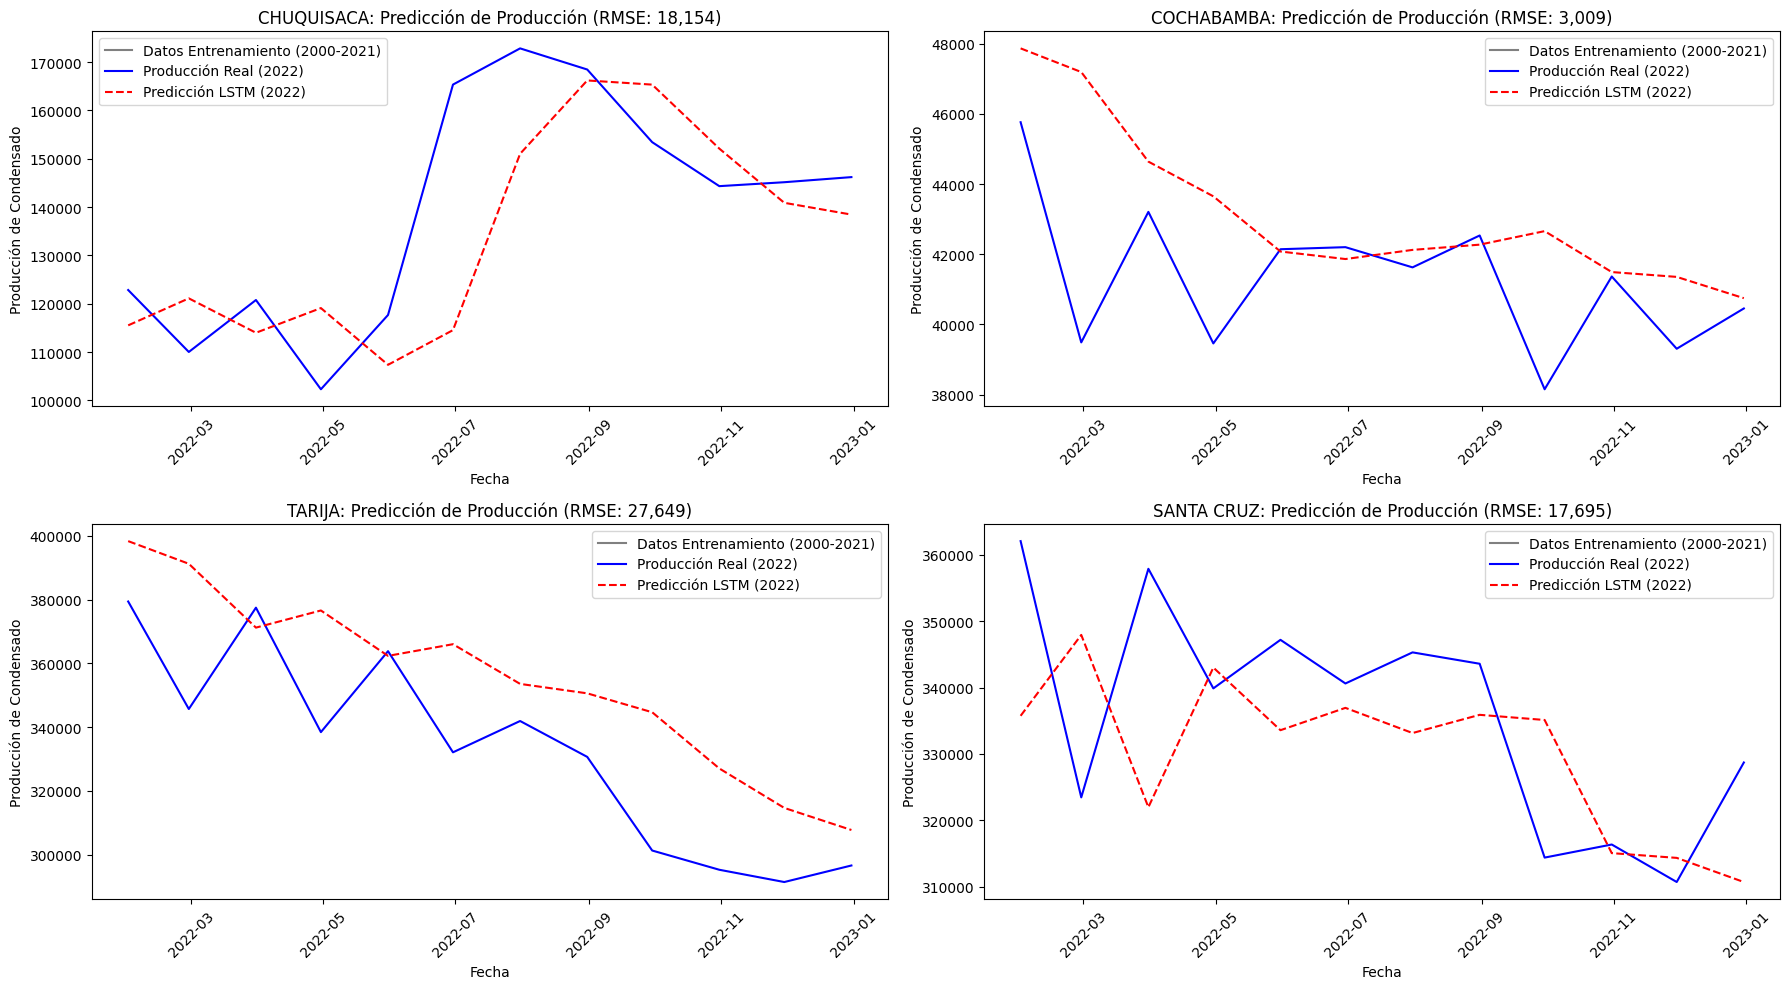

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


def create_dataset(data, look_back=12):
    """Crea conjuntos de datos X e Y para LSTM (mirando hacia atrás 'look_back' pasos)."""
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

def build_and_train_lstm(trainX, trainY, look_back):
    """Define y entrena el modelo LSTM con 100 unidades."""
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
    model = Sequential()

    # Mantenemos 100 unidades
    model.add(LSTM(100, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    print("Entrenando modelo...")
    # ⬇️ CAMBIO CLAVE PARA VELOCIDAD: Reducir épocas a 75 y aumentar batch_size a 5
    model.fit(trainX, trainY, epochs=75, batch_size=5, verbose=0)
    return model

# ==============================================================================
# PREPARACIÓN DEL DATAFRAME (ÍNDICE DE FECHA)
# ==============================================================================

# **ASUMIMOS QUE DF YA ESTÁ CARGADO Y CONTIENE 264 FILAS CON ÍNDICE DE FECHA**
# La creación del índice de fecha se realiza en la celda b9oLN2Jmo3lh


# ==============================================================================
# LOOP PRINCIPAL: ENTRENAMIENTO HASTA 2019 Y PREDICCIÓN RECURSIVA DESDE 2020
# ==============================================================================

departamentos = ['CHUQUISACA', 'COCHABAMBA', 'TARIJA', 'SANTA CRUZ']
look_back = 12
results = {}
total_data_length = len(df)

# Entrenar con datos hasta Diciembre 2021 (252 filas).
TRAIN_SIZE_FINAL = 252 # Number of data points up to Dec 2021
PREDICT_MONTHS = total_data_length - TRAIN_SIZE_FINAL # Predict from Jan 2022 to Dec 2022 (264 - 252 = 12 months)

for depto in departamentos:
    print(f"\n================ Procesando {depto} (Walk-Forward) ================")

    # 1. Extraer, transformar y escalar el dataset completo
    dataset = df[depto].values.astype('float32').reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)

    # 2. Definir conjuntos de entrenamiento y prueba (observado)
    train_data_scaled = dataset_scaled[0:TRAIN_SIZE_FINAL, :]

    # The actual values for the test period (Jan 2022 - Dec 2022)
    testY_actual_scaled = dataset_scaled[TRAIN_SIZE_FINAL:total_data_length, :]
    testY_actual_inversed = scaler.inverse_transform(testY_actual_scaled)

    # 3. Crear muestras de entrenamiento y entrenar el modelo
    trainX, trainY = create_dataset(train_data_scaled, look_back)
    model = build_and_train_lstm(trainX, trainY, look_back)

    # ==========================================================================
    # 4. PREDICCIÓN RECURSIVA (WALK-FORWARD) FOR THE FULL PREDICT_MONTHS
    # ==========================================================================

    # 4.1. Take the last window (Jan 2021 - Dec 2021) of data to start prediction
    last_window = train_data_scaled[-look_back:]
    current_input = last_window.reshape(1, look_back, 1)

    future_predictions_scaled = []

    for _ in range(PREDICT_MONTHS):
        # Predecir el siguiente punto
        next_prediction = model.predict(current_input, verbose=0)
        future_predictions_scaled.append(next_prediction[0, 0])

        # For the next step, use the actual value if available
        if TRAIN_SIZE_FINAL + _ < total_data_length:
             # Use the actual value if available
            real_value_next_month = dataset_scaled[TRAIN_SIZE_FINAL + _].reshape(1, 1, 1)
        else:
            # This case should not be reached with the current PREDICT_MONTHS definition,
            # but it's good practice for potential future use cases.
            real_value_next_month = next_prediction.reshape(1, 1, 1)


        # Create the new window: Shift and add the value (actual or predicted) for the next step
        new_window = np.append(current_input[:, 1:, :], real_value_next_month, axis=1)
        current_input = new_window


    # 5. Inverse Scaling
    y_pred_inversed_full = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))[:,0]
    # The true values are the test set actual values
    y_true = testY_actual_inversed[:,0]


    # 6. Evaluation: Calculate metrics (MAE, RMSE, R2) for the test period (Jan 2022 - Dec 2022)
    # Ensure y_true and y_pred_inversed_full have the same length
    min_len = min(len(y_true), len(y_pred_inversed_full))
    y_true_sliced = y_true[:min_len]
    y_pred_inversed_full_sliced = y_pred_inversed_full[:min_len]


    rmse = np.sqrt(mean_squared_error(y_true_sliced, y_pred_inversed_full_sliced))
    mae = mean_absolute_error(y_true_sliced, y_pred_inversed_full_sliced)
    r2 = r2_score(y_true_sliced, y_pred_inversed_full_sliced)

    print(f"--- Métricas para {depto} (Walk-Forward 2022) ---")
    print(f" MAE:  {mae:,.2f}")
    print(f" RMSE: {rmse:,.2f}")
    print(f" R2:   {r2:.4f}")

    # 7. Store results
    results[depto] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'testY': y_true, # Actual values for the test period (Jan 2022 - Dec 2022)
        'predY': y_pred_inversed_full, # Predictions for the test period (Jan 2022 - Dec 2022)
        'train_size_used': TRAIN_SIZE_FINAL
    }

# ==============================================================================
# VISUALIZATION OF RESULTS
# ==============================================================================

plt.figure(figsize=(18, 10))

for i, depto in enumerate(departamentos):
    if depto in results:
        res = results[depto]

        plt.subplot(2, 2, i + 1)

        train_size_final = res['train_size_used']

        # TIME INDEX: For the test period (Jan 2022 - Dec 2022)
        start_index_test = train_size_final
        end_index_test = total_data_length
        time_index_test = df.index[start_index_test:end_index_test]


        # Plotting Context (Last two years of training: 2020-2021)
        context_start = train_size_final #- 24 # Starts in Jan 2020
        context_end = train_size_final # Ends in Dec 2021
        context_index = df.index[context_start:context_end]
        context_values = df[depto].values[context_start:context_end]
        plt.plot(context_index, context_values, label='Datos Entrenamiento (2000-2021)', color='gray', linestyle='-')


        # Plotting the Prediction
        plt.plot(time_index_test, res['testY'], label='Producción Real (2022)', color='blue')
        plt.plot(time_index_test, res['predY'], label='Predicción LSTM (2022)', color='red', linestyle='--')


        plt.title(f'{depto}: Predicción de Producción (RMSE: {res["rmse"]:,.0f})')
        plt.xlabel('Fecha')
        plt.ylabel('Producción de Condensado')
        plt.legend()
        plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

bien
